# Load, Reproject, and Export Chlorophyll Data

Finally, we're ready to do something with the cholorophyll data product from the Sentinel-3 OLCI instrument. We use the library `satpy` to load the data, reproject it into a suitable grid at a suitable resolution, and then export the layer as Geotiff. Afterwards, we can use do some downstream analytics (for example, building indices and timeseries), stitch multiple tiles together, or serve the Geotiff through an XYZ tileserver (like [Terracotta](https://terracotta-python.readthedocs.io/en/latest/)) for further integrations.

Alternatives:

Instead of `satpy`, we could also have used to `EOReader` Python to load and automatically reproject the source data. However, `EOReader` focusses on a certain subsets of bands (as it designed for specific use-cases in rapid disaster response). That said, the code that `EOReader` uses to load and reproject data is instructive if you don't want to depend on `satpy`.

References:

- https://satpy.readthedocs.io/en/stable/
- https://github.com/johannesocean/senplot
- https://eoreader.readthedocs.io/en/latest/notebooks/sentinel-3.html
- https://github.com/sertit/eoreader/blob/main/eoreader/products/optical/s3_product.py#L597

## Preliminaries

In [1]:
%matplotlib inline

In [2]:
import satpy
import numpy as np
import pprint

## Load Data

In [3]:
basedir = 'data'

In [4]:
file_names = satpy.find_files_and_readers(sensor='olci',
                                          reader='olci_l2',
                                          base_dir=basedir)
pprint.pprint(file_names)

{'olci_l2': ['data/S3A_OL_2_WFR____20190603T095937_20190603T100237_20190604T203202_0179_045_236_1800_MAR_O_NT_002.SEN3/Oa16_reflectance.nc',
             'data/S3A_OL_2_WFR____20190603T095937_20190603T100237_20190604T203202_0179_045_236_1800_MAR_O_NT_002.SEN3/Oa21_reflectance.nc',
             'data/S3A_OL_2_WFR____20190603T095937_20190603T100237_20190604T203202_0179_045_236_1800_MAR_O_NT_002.SEN3/Oa09_reflectance.nc',
             'data/S3A_OL_2_WFR____20190603T095937_20190603T100237_20190604T203202_0179_045_236_1800_MAR_O_NT_002.SEN3/Oa07_reflectance.nc',
             'data/S3A_OL_2_WFR____20190603T095937_20190603T100237_20190604T203202_0179_045_236_1800_MAR_O_NT_002.SEN3/Oa06_reflectance.nc',
             'data/S3A_OL_2_WFR____20190603T095937_20190603T100237_20190604T203202_0179_045_236_1800_MAR_O_NT_002.SEN3/Oa12_reflectance.nc',
             'data/S3A_OL_2_WFR____20190603T095937_20190603T100237_20190604T203202_0179_045_236_1800_MAR_O_NT_002.SEN3/Oa05_reflectance.nc',
             

In [5]:
scene = satpy.Scene(filenames=file_names, reader='olci_l2')

In [6]:
datasets = ['chl_nn']

In [7]:
scene.load(datasets)

/Users/volkerh/miniforge3/envs/iliad/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


## Preprocessing

Data CHL_NN product is in units log10(mg/m^3) = log10(µg/l).

If you want the data linearly spaced, this is your chance to transform.

In [8]:
# scene['chl_nn'] = np.power(10, scene['chl_nn'])

## Reproject Data

In `Satpy`, we use area definitions to define the target grid (and area) the data should reprojected into. You can define that area manually or use some of the predefined areas. In our case, we use the Northern Europe area definition with 1km resolution and EPSG:4326 (WGS84) as spatial reference system.

See https://satpy.readthedocs.io/en/stable/resample.html.

In [9]:
#
# Option 1 - A 1km Grid
# 

# Europe (or Norther Europe) at 1km resolution
# Sentinl-3 data is in ~300m resolution.
# The `nearest` resampler uses a KDTree, so we pass 300m  as the radius of influence.
# area_spec = 'arctic_europe_1km'
area_spec = 'euron1'
scene = scene.resample(area_spec, resampler='nearest', radius_of_influence=300)

#
# Option 2 -- A 250m Grid
#

# To reproject onto a finer grid, we need to do bilinear resampling.
# Be careful, this invents some data (through interpolation).
# It is also extremely slow.

# area_spec = 'euron0250'
# scene = scene.resample(area_spec, resampler='bilinear')  # very slow!!!

## Quick Plot

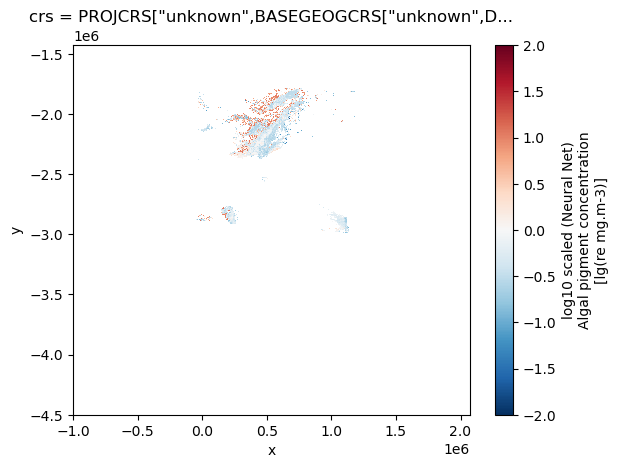

In [10]:
scene['chl_nn'].plot()
pass

## Export to GeoTiff

This exports the layer to GeoTiff. We make sure to export as [Cloud Optimized Geotiff](https://www.cogeo.org).

See also https://satpy.readthedocs.io/en/stable/api/satpy.writers.geotiff.html#module-satpy.writers.geotiff.

In [11]:
scene.save_dataset(
   'chl_nn',
    filename='test.tif',
    writer='geotiff',
    dtype=np.float32,
    enhance=False,
    driver='COG',  # Cloud Optimized Geotiff 
)

## What Now?

The Geotiff containes metadata about the spatial reference (SRS) for the data.

Given that, you should be able to

1. Drag the file into [QGIS](https://qgis.org).
2. Serve the file up with [Terracotta](https://github.com/DHI/terracotta).